# Sentiment analysis - Bag of words meets bags of popcorn dataset
## IMDB dataset for NLP analysis

### 1. Introduction

The goal of this project is to get familiar with Bag of Words model, commonly used in text classification. I'm using a relatively simple Kaggle dataset "Bag of words meets bags of popcorn" which can be found [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). The data set consists of 25,000 IMDB movie reviews, specially selected for sentiment analysis. The classification is suppose to determine whether the review is positive or negative.

### 2. Data exploration

Data set consists of 25000 entries, each with 3 parameters: id, sentiment, and review. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('C:\insight_program\ml_bag_popcorn\labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
df.shape

(25000, 3)

It seems that all id's are unique (refer to a unique movie), so at this time, I'll only keep the sentiment and review columns.

In [4]:
len(df['id'].unique())

25000

In [5]:
col = ['sentiment', 'review']
df = df[col]
#dropping columns to prevent memory error
#df = df[:-5000]
df = df[:-15000]

### 3. Text preprocessing

Text of the reviews needs to be preprocessed. I will remove html notation, convert all letters to lowercase, remove numbers and punctuation. The vectorization algoritm itself has the option for dealing with stop words, so I won't be addressing that here.

In [6]:
print(df['review'][12])

\Mr. Harvey Lights a Candle\" is anchored by a brilliant performance by Timothy Spall.<br /><br />While we can predict that his titular morose, up tight teacher will have some sort of break down or catharsis based on some deep down secret from his past, how his emotions are unveiled is surprising. Spall's range of feelings conveyed is quite moving and more than he usually gets to portray as part of the Mike Leigh repertory.<br /><br />While an expected boring school bus trip has only been used for comic purposes, such as on \"The Simpsons,\" this central situation of a visit to Salisbury Cathedral in Rhidian Brook's script is well-contained and structured for dramatic purposes, and is almost formally divided into acts.<br /><br />We're introduced to the urban British range of racially and religiously diverse kids (with their uniforms I couldn't tell if this is a \"private\" or \"public\" school), as they gather  the rapping black kids, the serious South Asians and Muslims, the white b

In [7]:
import re

In [8]:
#defining function to clean up the text
from bs4 import BeautifulSoup
import re

def review_to_text(raw_review):
    """Function to convert raw review text to string of words
    input: raw review text
    output: prepocessed review text (removed html tags, converted to lowercase, removed numbers and punctuation)
    """
    # remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # remove numbers and punctuation      
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    return (" ".join(words))

Here's an example of a processed review:

In [9]:
clean_review = review_to_text( df['review'][12])
print (clean_review)

mr harvey lights a candle is anchored by a brilliant performance by timothy spall while we can predict that his titular morose up tight teacher will have some sort of break down or catharsis based on some deep down secret from his past how his emotions are unveiled is surprising spall s range of feelings conveyed is quite moving and more than he usually gets to portray as part of the mike leigh repertory while an expected boring school bus trip has only been used for comic purposes such as on the simpsons this central situation of a visit to salisbury cathedral in rhidian brook s script is well contained and structured for dramatic purposes and is almost formally divided into acts we re introduced to the urban british range of racially and religiously diverse kids with their uniforms i couldn t tell if this is a private or public school as they gather the rapping black kids the serious south asians and muslims the white bullies and mean girls but conveyed quite naturally and individual

Now we can apply preprocessing function to all the reviews in the data set:

In [10]:
num_reviews = df['review'].size
clean_text_reviews = []

for i in range(num_reviews):
    '''if ((i+1)%1000 == 0):
        print("Processed %d reviews of %d reviews total\n" % (i+1, num_reviews))'''
    clean_text_reviews.append(review_to_text(df['review'][i]))

df['clean_review'] = clean_text_reviews

In [11]:
print(df['clean_review'][12])

mr harvey lights a candle is anchored by a brilliant performance by timothy spall while we can predict that his titular morose up tight teacher will have some sort of break down or catharsis based on some deep down secret from his past how his emotions are unveiled is surprising spall s range of feelings conveyed is quite moving and more than he usually gets to portray as part of the mike leigh repertory while an expected boring school bus trip has only been used for comic purposes such as on the simpsons this central situation of a visit to salisbury cathedral in rhidian brook s script is well contained and structured for dramatic purposes and is almost formally divided into acts we re introduced to the urban british range of racially and religiously diverse kids with their uniforms i couldn t tell if this is a private or public school as they gather the rapping black kids the serious south asians and muslims the white bullies and mean girls but conveyed quite naturally and individual

Before we start classifying, let's check how balanced are the two sets? Grouped by sentiment.

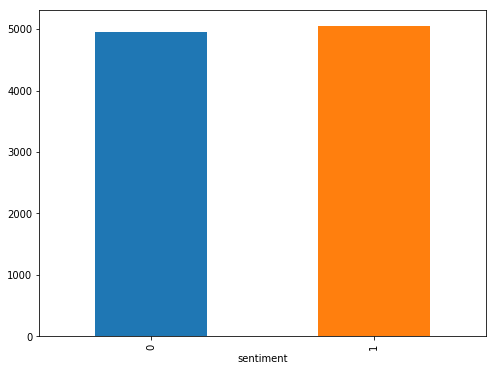

In [12]:
# How balanced are the sets
fig = plt.figure(figsize=(8,6))
df.groupby('sentiment').clean_review.count().plot.bar(ylim=0)
plt.show()

Also, are there any missing values in the sets?

In [13]:
df.isnull().values.any()

False

### 4. Text representation (aka feature extraction)

First, I'm goint to calculate TF-IDF parameter

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.clean_review).toarray()
print(features.shape)

(10000, 32916)


In [15]:
#feature selection using chi2 to find the terms most correlated to sentiment
from sklearn.feature_selection import chi2
import numpy as np

N=2
for sentiments in [0,1]:
    # print(df.sentiment == sentiments)
    features_chi2 = chi2(features, df.sentiment == sentiments)
    indices = np.argsort(features_chi2[0])
    print(indices)
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(sentiments)
    print(" . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

[10148  5892 29198 ... 31597 32500  1784]
0
 . Most correlated unigrams:
. worst
. bad
 . Most correlated bigrams:
. worst movie
. waste time
[10148  5892 29198 ... 31597 32500  1784]
1
 . Most correlated unigrams:
. worst
. bad
 . Most correlated bigrams:
. worst movie
. waste time


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [17]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train_tfidf, y_train)

After fitting the data set, let's make some predictions using random reviews from IMDB

In [18]:
print(clf.predict(count_vect.transform(["This movie is great."])))
print(clf.predict(count_vect.transform(["This is the best movie I've ever seen in a long time the fast and the furious"
                                        "is a awsome movie with a great story awsome animation unforgettable characters"
                                        "and songs that will set you free this is a must watched movie for everybody who"
                                        "like games like need for speed underground 2 and spy movies like spy kids I give it a 10/10"])))
print(clf.predict(count_vect.transform(["They really tried to make the film more than just a racer, but it couldn't keep"
                                        "my attention span for more than 10 minutes at a time, I kept looking for something"
                                        "else to do. The tunnel racing was nicely done, but that's about the only highlight for me. "])))

print(clf.predict(count_vect.transform(["Since we can't give negative scores this was the only logical score i could give."
                                        "The worst acting ever seen, the worst story ever. Every event turn out to be less"
                                        "logical than a man marruing a jellyfish. All the answer came out from nowhere."
                                        "Why do Brian knew who was the culprit without anyone telling him about it?."
                                        "In the church (the most ridiculous scene in the movie); Why do Brian hang a pistol"
                                        "when the other one was using a shootgun?. Please god, I BEG YOU, Don't ever let another F&F film be made ever again."])))


[1]
[1]
[0]
[0]


I've experimented with different ML models: Naive Bayes, Linear SVM, Random Forest and Logistic Regression.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

print(features.shape)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]

CV=5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    print(model)
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, df.sentiment, cv=CV, pre_dispatch=1)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name','fold_idx','accuracy'])

print(cv_df.groupby('model_name')['accuracy'].mean())

(10000, 32916)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

model_name
LinearSVC                 0.884200
LogisticRegression        0.878201
MultinomialNB             0.870701
RandomForestClassifier    0.776700
Name: accuracy, dtype: float64
